In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, GlobalAveragePooling2D, Input, Bidirectional, LSTM, TimeDistributed, RNN, BatchNormalization
from tensorflow.keras import callbacks 
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
from tqdm import tqdm
import itertools
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import numpy as np
import shutil
import cv2
import os

print ('Library loaded')

Library loaded


In [2]:
os.mkdir('/kaggle/working/file_training')

In [3]:
inp = '/kaggle/input/lung-disease-5-class'
os.listdir(inp)

['viral_pneumonia', 'tuberculosis', 'normal', 'covid19', 'bacterial_pneumonia']

In [4]:
input_dir = '/kaggle/input/lung-disease-5-class'
output_dir = '/kaggle/working/lung disease'

shutil.copytree(input_dir, output_dir)

print("Isi dari direktori output:")
print(os.listdir(output_dir))

Isi dari direktori output:
['normal', 'covid19', 'tuberculosis', 'bacterial_pneumonia', 'viral_pneumonia']


In [5]:
classes = ['bacterial_pneumonia', 'covid19', 'normal', 'tuberculosis', 'viral_pneumonia']
inp2 = '/kaggle/working/lung disease'

lungdisease_dir = os.path.join(inp2, 'lungdisease')
os.makedirs(lungdisease_dir, exist_ok=True)

train_dir = os.path.join(lungdisease_dir, 'train_dir')
os.makedirs(train_dir, exist_ok=True)

test_dir = os.path.join(lungdisease_dir, 'test_dir')
os.makedirs(test_dir, exist_ok=True)

for class_name in classes:
    os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

for class_name in classes:
    class_dir = os.path.join(inp2, class_name)
    files = os.listdir(class_dir)
    train_files, test_files = train_test_split(files, test_size=0.2, random_state=42)
    
    for file in train_files:
        src = os.path.join(class_dir, file)
        dest = os.path.join(train_dir, class_name, file)
        shutil.copy(src, dest)
        
    for file in test_files:
        src = os.path.join(class_dir, file)
        dest = os.path.join(test_dir, class_name, file)
        shutil.copy(src, dest)

print("Berhasil.")


Berhasil.


In [6]:
train_dir = os.path.join(inp2, 'lungdisease', 'train_dir')
test_dir = os.path.join(inp2, 'lungdisease', 'test_dir')

print("Jumlah gambar untuk setiap kelas di train_dir:")
for class_name in classes:
    class_path = os.path.join(train_dir, class_name)
    num_files = len(os.listdir(class_path))
    print(f"{class_name}: {num_files} gambar")

print("\nJumlah gambar untuk setiap kelas di test_dir:")
for class_name in classes:
    class_path = os.path.join(test_dir, class_name)
    num_files = len(os.listdir(class_path))
    print(f"{class_name}: {num_files} gambar")

Jumlah gambar untuk setiap kelas di train_dir:
bacterial_pneumonia: 820 gambar
covid19: 843 gambar
normal: 835 gambar
tuberculosis: 560 gambar
viral_pneumonia: 862 gambar

Jumlah gambar untuk setiap kelas di test_dir:
bacterial_pneumonia: 206 gambar
covid19: 211 gambar
normal: 209 gambar
tuberculosis: 140 gambar
viral_pneumonia: 216 gambar


In [7]:
train_dir = os.path.join(inp2, 'lungdisease', 'train_dir')
test_dir = os.path.join(inp2, 'lungdisease', 'test_dir')

total_train_data = sum([len(files) for _, _, files in os.walk(train_dir)])

total_test_data = sum([len(files) for _, _, files in os.walk(test_dir)])

print(f"Total data pada train_dir: {total_train_data}")
print(f"Total data pada test_dir: {total_test_data}")

Total data pada train_dir: 3920
Total data pada test_dir: 982


In [8]:
#augmentasi gambar
base = '/kaggle/working/lung disease/lungdisease'
class_name = ["bacterial_pneumonia", "covid19", "normal", "tuberculosis", "viral_pneumonia"]
for img_class in class_name:
    aug_dir = os.path.join(base, "aug_dir")
    os.mkdir(aug_dir)
    img_dir = os.path.join(aug_dir, "img_dir")
    os.mkdir(img_dir)

    img_list = os.listdir(
        os.path.join(base, "train_dir", img_class)
    )
    for file_name in img_list:
        source = os.path.join(
            base, "train_dir", img_class, file_name
        )
        target = os.path.join(img_dir, file_name)
        shutil.copyfile(source, target)

    source_path = aug_dir
    save_path = os.path.join(base, "train_dir", img_class)
    batch_size = 50

    datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rotation_range=90,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.05,
    )

    aug_datagen = datagen.flow_from_directory(
        source_path,
        save_to_dir=save_path,
        save_format="jpg",
        target_size=(224, 224),
        batch_size=batch_size,
    )
    aug_images = 1200

    num_files = len(os.listdir(img_dir))
    num_batches = int(np.ceil((aug_images - num_files) / batch_size))

    for i in range(0, num_batches):
        images, labels = next(aug_datagen)

    # hapus temporary directory
    shutil.rmtree(aug_dir)

Found 820 images belonging to 1 classes.
Found 843 images belonging to 1 classes.
Found 835 images belonging to 1 classes.
Found 560 images belonging to 1 classes.
Found 862 images belonging to 1 classes.


In [9]:
#menghitung total kelas setelah augmentasi pada train set
def count_images_per_class(directory):
    class_counts = {}

    for img_class in os.listdir(directory):
        class_path = os.path.join(directory, img_class)
        if os.path.isdir(class_path):
            num_images = len(os.listdir(class_path))
            class_counts[img_class] = num_images

    return class_counts


augmented_train_dir = os.path.join(base, "train_dir")

augmented_class_counts = count_images_per_class(augmented_train_dir)

print("Banyak gambar per kelas pada train_df setelah augmentasi:")
for img_class, count in augmented_class_counts.items():
    print(f"{img_class}: {count} images")

Banyak gambar per kelas pada train_df setelah augmentasi:
normal: 1235 images
covid19: 1243 images
tuberculosis: 1170 images
bacterial_pneumonia: 1220 images
viral_pneumonia: 1212 images


In [10]:
train_path = '/kaggle/working/lung disease/lungdisease/train_dir'
test_path = '/kaggle/working/lung disease/lungdisease/test_dir'

batch_size = 32

image_size = 224

## ResNet50

In [11]:
datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input)

train_batches = datagen.flow_from_directory(train_path,
                                            target_size=(image_size,image_size),
                                            batch_size=batch_size,shuffle=True)

test_batches = datagen.flow_from_directory(test_path,
                                            target_size=(image_size,image_size),
                                            batch_size=batch_size,shuffle=False)

Found 6080 images belonging to 5 classes.
Found 982 images belonging to 5 classes.


In [12]:
base_model_resnet50 = tf.keras.applications.ResNet50(
    include_top=False, weights="imagenet", input_shape=(image_size, image_size, 3)
)

for layer in base_model_resnet50.layers:
    layer.trainable = False

94781440/94765736 [==============================] - 1s 0us/step


In [13]:
model_resnet50 = Sequential()
model_resnet50.add(base_model_resnet50)
model_resnet50.add(GlobalAveragePooling2D())
model_resnet50.add(BatchNormalization())
model_resnet50.add(Dense(128, activation='relu'))
model_resnet50.add(Dropout(0.25))
model_resnet50.add(Dense(64, activation="relu"))
model_resnet50.add(Dropout(0.5))
model_resnet50.add(Dense(32, activation="relu"))
model_resnet50.add(Dense(5, activation="softmax"))

model_resnet50.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 2048)              8192      
_________________________________________________________________
dense (Dense)                (None, 128)               262272    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0

In [14]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)

model_resnet50.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['acc'])

checkpoint = ModelCheckpoint(
    filepath="/kaggle/working/file_training/resnet50.h5",
    monitor="val_acc",
    save_best_only=True,
    verbose=1,
    mode="max",
)

reduce_lr = ReduceLROnPlateau(
    monitor="val_acc",
    factor=0.5,
    patience=2,
    verbose=1,
    mode="max",
    min_lr=1e-6,
)

early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=7,
    restore_best_weights=True,
)

In [15]:
history_resnet50 = model_resnet50.fit(train_batches, validation_data=test_batches, epochs=25, verbose=1, callbacks=[early_stopping, reduce_lr])

Epoch 1/25
190/190 [==============================] - 41s 154ms/step - loss: 0.7724 - acc: 0.7008 - val_loss: 0.3118 - val_acc: 0.8931
Epoch 2/25
190/190 [==============================] - 28s 145ms/step - loss: 0.4230 - acc: 0.8406 - val_loss: 0.1990 - val_acc: 0.9338
Epoch 3/25
190/190 [==============================] - 28s 146ms/step - loss: 0.3140 - acc: 0.8849 - val_loss: 0.1622 - val_acc: 0.9348
Epoch 4/25
190/190 [==============================] - 28s 147ms/step - loss: 0.2695 - acc: 0.9012 - val_loss: 0.1525 - val_acc: 0.9399
Epoch 5/25
190/190 [==============================] - 27s 144ms/step - loss: 0.2315 - acc: 0.9168 - val_loss: 0.1351 - val_acc: 0.9511
Epoch 6/25
190/190 [==============================] - 28s 145ms/step - loss: 0.1913 - acc: 0.9275 - val_loss: 0.1302 - val_acc: 0.9562
Epoch 7/25
190/190 [==============================] - 27s 144ms/step - loss: 0.1778 - acc: 0.9368 - val_loss: 0.1247 - val_acc: 0.9562
Epoch 8/25
190/190 [==============================] - 2

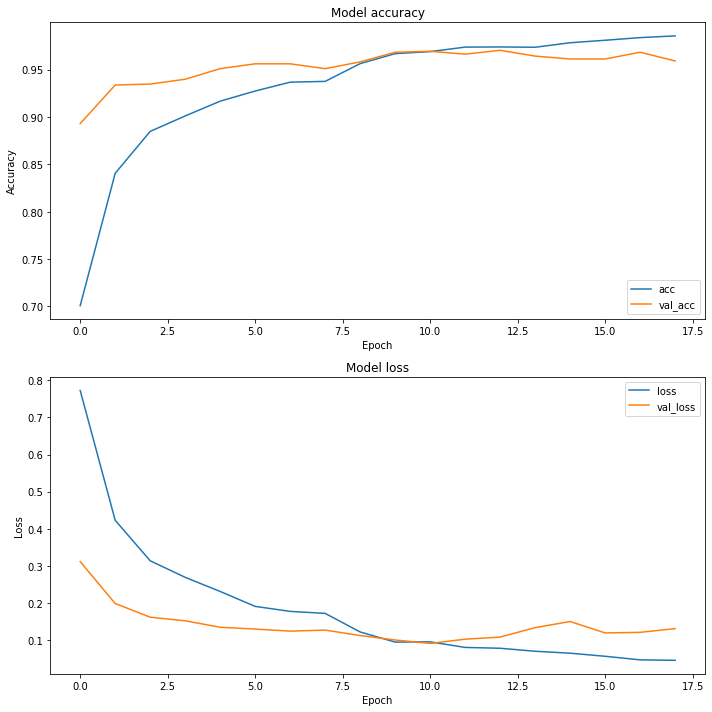

In [16]:
plt.figure(figsize=(10,10))
# Plot grafik akurasi
plt.subplot(2, 1, 1)
plt.plot(history_resnet50.history["acc"])
plt.plot(history_resnet50.history["val_acc"])
plt.title("Model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["acc", "val_acc"], loc="lower right")

# Plot grafik loss
plt.subplot(2, 1, 2)
plt.plot(history_resnet50.history["loss"])
plt.plot(history_resnet50.history["val_loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["loss", "val_loss"], loc="upper right")

plt.tight_layout()  # Agar grafik tidak tumpang tindih
plt.show()


In [17]:
train_score = model_resnet50.evaluate(train_batches, verbose=1)
test_score = model_resnet50.evaluate(test_batches, verbose=1)

31/31 [==============================] - 5s 155ms/step - loss: 0.0916 - acc: 0.9695


In [18]:
model_resnet50.save("/kaggle/working/file_training/resnet50.h5")

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [19]:
y_true = np.array([])
for i in range(len(test_batches)):
    batch = next(test_batches)
    y_true = np.concatenate([y_true, np.argmax(batch[1], axis=1)])

classname_label = list(test_batches.class_indices.keys())
print(classname_label)

['bacterial_pneumonia', 'covid19', 'normal', 'tuberculosis', 'viral_pneumonia']


Found 982 images belonging to 5 classes.
31/31 [==============================] - 5s 148ms/step

Classification Report:
                      precision    recall  f1-score   support

bacterial_pneumonia    0.97073   0.96602   0.96837       206
            covid19    0.98507   0.93839   0.96117       211
             normal    0.96262   0.98565   0.97400       209
       tuberculosis    0.98582   0.99286   0.98932       140
    viral_pneumonia    0.95023   0.97222   0.96110       216

           accuracy                        0.96945       982
          macro avg    0.97089   0.97103   0.97079       982
       weighted avg    0.96973   0.96945   0.96941       982



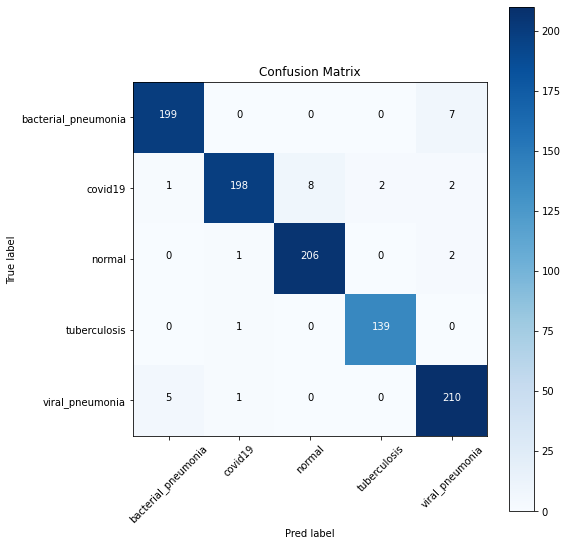

In [20]:
test_all_batches = datagen.flow_from_directory(
    directory=test_path,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    shuffle=False,
    class_mode="categorical",
)
true_labels = test_batches.classes

num_test_steps = len(test_all_batches)

predictions = model_resnet50.predict(test_batches, steps=num_test_steps, verbose=1)
predicted_labels = np.argmax(predictions, axis=1)
class_report = classification_report(
    true_labels, predicted_labels, target_names=train_batches.class_indices, digits=5
)
print("\nClassification Report:\n", class_report)

conf_matrix = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(8, 8))
plt.imshow(conf_matrix, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(classname_label))
plt.xticks(tick_marks, classname_label, rotation=45)
plt.yticks(tick_marks, classname_label)
thresh = conf_matrix.max() / 2.0
for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
    plt.text(
        j,
        i,
        conf_matrix[i, j],
        horizontalalignment="center",
        color="white" if conf_matrix[i, j] > thresh else "black",
    )

plt.tight_layout()
plt.ylabel("True label")
plt.xlabel("Pred label")
plt.show()

In [21]:
y_true = np.array([])
for i in range(len(train_batches)):
    batch = next(train_batches)
    y_true = np.concatenate([y_true, np.argmax(batch[1], axis=1)])

classname_label = list(train_batches.class_indices.keys())
print(classname_label)

['bacterial_pneumonia', 'covid19', 'normal', 'tuberculosis', 'viral_pneumonia']


Found 6080 images belonging to 5 classes.
190/190 [==============================] - 24s 127ms/step

Training Classification Report:
                      precision    recall  f1-score   support

bacterial_pneumonia    0.99917   0.98525   0.99216      1220
            covid19    0.99919   0.99276   0.99596      1243
             normal    0.99435   0.99676   0.99555      1235
       tuberculosis    0.99829   1.00000   0.99915      1170
    viral_pneumonia    0.98295   0.99917   0.99100      1212

           accuracy                        0.99474      6080
          macro avg    0.99479   0.99479   0.99476      6080
       weighted avg    0.99479   0.99474   0.99474      6080



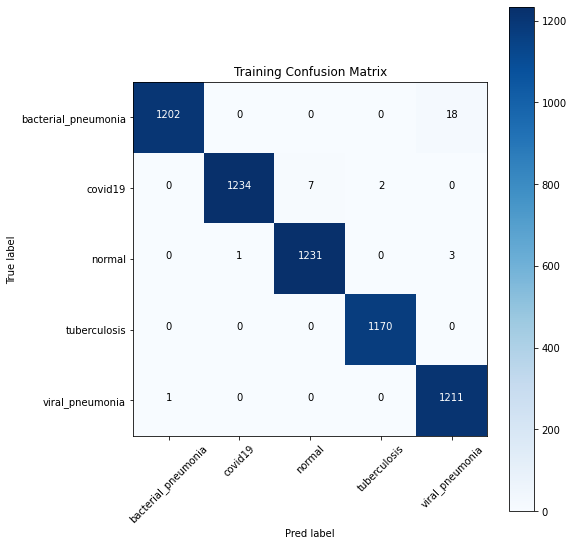

In [22]:
train_all_batches = datagen.flow_from_directory(
    directory=train_path,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    shuffle=False,
    class_mode="categorical",
)

num_train_steps = len(train_all_batches)

train_predictions = model_resnet50.predict(train_all_batches, steps=num_train_steps, verbose=1)
train_predicted_labels = np.argmax(train_predictions, axis=1)
train_true_labels = train_all_batches.classes

train_class_report = classification_report(
    train_true_labels,
    train_predicted_labels,
    target_names=train_all_batches.class_indices,
    digits=5,
)
print("\nTraining Classification Report:\n", train_class_report)

train_conf_matrix = confusion_matrix(train_true_labels, train_predicted_labels)

# Plot
plt.figure(figsize=(8, 8))
plt.imshow(train_conf_matrix, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Training Confusion Matrix")
plt.colorbar()

tick_marks = np.arange(len(classname_label))
plt.xticks(tick_marks, classname_label, rotation=45)
plt.yticks(tick_marks, classname_label)

thresh = train_conf_matrix.max() / 2.0
for i, j in itertools.product(
    range(train_conf_matrix.shape[0]), range(train_conf_matrix.shape[1])
):
    plt.text(
        j,
        i,
        train_conf_matrix[i, j],
        horizontalalignment="center",
        color="white" if train_conf_matrix[i, j] > thresh else "black",
    )

plt.tight_layout()
plt.ylabel("True label")
plt.xlabel("Pred label")
plt.show()

## VGG19

In [23]:
datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg19.preprocess_input)

train_batches = datagen.flow_from_directory(train_path,
                                            target_size=(image_size,image_size),
                                            batch_size=batch_size,shuffle=True)

test_batches = datagen.flow_from_directory(test_path,
                                            target_size=(image_size,image_size),
                                            batch_size=batch_size,shuffle=False)

Found 6080 images belonging to 5 classes.
Found 982 images belonging to 5 classes.


In [24]:
base_model_vgg19 = tf.keras.applications.VGG19(
    include_top=False, weights="imagenet", input_shape=(image_size, image_size, 3)
)

for layer in base_model_vgg19.layers:
    layer.trainable = False

80150528/80134624 [==============================] - 0s 0us/step


In [25]:
model_vgg19 = Sequential()
model_vgg19.add(base_model_vgg19)
model_vgg19.add(GlobalAveragePooling2D())
model_vgg19.add(BatchNormalization())
model_vgg19.add(Dense(128, activation='relu'))
model_vgg19.add(Dropout(0.25))
model_vgg19.add(Dense(64, activation="relu"))
model_vgg19.add(Dropout(0.5))
model_vgg19.add(Dense(32, activation="relu"))
model_vgg19.add(Dense(5, activation="softmax"))

model_vgg19.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
dense_4 (Dense)              (None, 128)               65664     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)               

In [26]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)

model_vgg19.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['acc'])

checkpoint = ModelCheckpoint(
    filepath="/kaggle/working/file_training/vgg19.h5",
    monitor="val_acc",
    save_best_only=True,
    verbose=1,
    mode="max",
)

reduce_lr = ReduceLROnPlateau(
    monitor="val_acc",
    factor=0.5,
    patience=2,
    verbose=1,
    mode="max",
    min_lr=1e-6,
)

early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=7,
    restore_best_weights=True,
)

In [27]:
history_vgg19 = model_vgg19.fit(train_batches, validation_data=test_batches, epochs=25, verbose=1, callbacks=[early_stopping, reduce_lr])

Epoch 1/25
190/190 [==============================] - 49s 219ms/step - loss: 0.9535 - acc: 0.6215 - val_loss: 0.4876 - val_acc: 0.7943
Epoch 2/25
190/190 [==============================] - 36s 191ms/step - loss: 0.5389 - acc: 0.7919 - val_loss: 0.3010 - val_acc: 0.8951
Epoch 3/25
190/190 [==============================] - 37s 192ms/step - loss: 0.4145 - acc: 0.8403 - val_loss: 0.2570 - val_acc: 0.9063
Epoch 4/25
190/190 [==============================] - 37s 192ms/step - loss: 0.3738 - acc: 0.8604 - val_loss: 0.2399 - val_acc: 0.9104
Epoch 5/25
190/190 [==============================] - 37s 193ms/step - loss: 0.3379 - acc: 0.8694 - val_loss: 0.2291 - val_acc: 0.9114
Epoch 6/25
190/190 [==============================] - 37s 192ms/step - loss: 0.2868 - acc: 0.8883 - val_loss: 0.2171 - val_acc: 0.9236
Epoch 7/25
190/190 [==============================] - 37s 193ms/step - loss: 0.2906 - acc: 0.8959 - val_loss: 0.2067 - val_acc: 0.9246
Epoch 8/25
190/190 [==============================] - 3

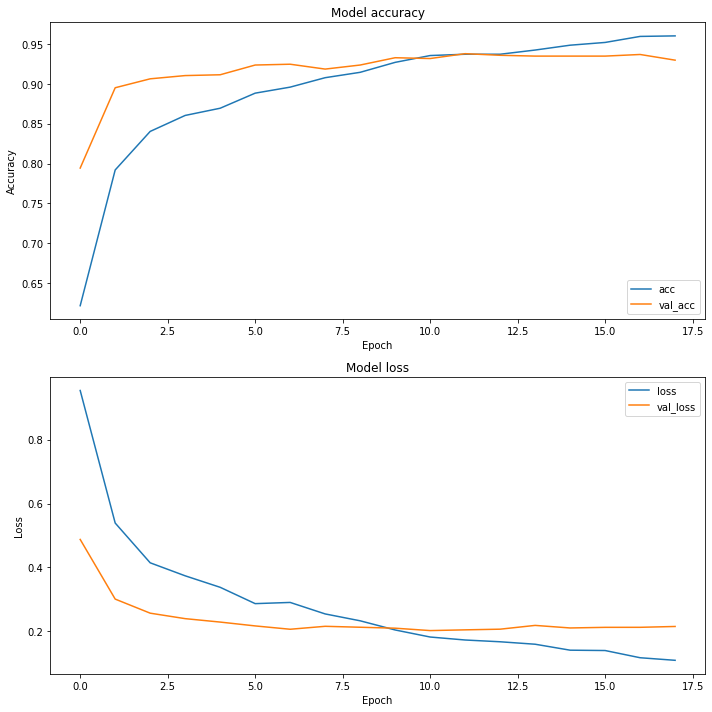

In [28]:
plt.figure(figsize=(10,10))
# Plot grafik akurasi
plt.subplot(2, 1, 1)
plt.plot(history_vgg19.history["acc"])
plt.plot(history_vgg19.history["val_acc"])
plt.title("Model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["acc", "val_acc"], loc="lower right")

# Plot grafik loss
plt.subplot(2, 1, 2)
plt.plot(history_vgg19.history["loss"])
plt.plot(history_vgg19.history["val_loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["loss", "val_loss"], loc="upper right")

plt.tight_layout()  # Agar grafik tidak tumpang tindih
plt.show()


In [29]:
train_score = model_vgg19.evaluate(train_batches, verbose=1)
test_score = model_vgg19.evaluate(test_batches, verbose=1)

31/31 [==============================] - 6s 186ms/step - loss: 0.2025 - acc: 0.9318


In [30]:
model_vgg19.save("/kaggle/working/file_training/vgg19.h5")

In [31]:
y_true = np.array([])
for i in range(len(test_batches)):
    batch = next(test_batches)
    y_true = np.concatenate([y_true, np.argmax(batch[1], axis=1)])

classname_label = list(test_batches.class_indices.keys())
print(classname_label)

['bacterial_pneumonia', 'covid19', 'normal', 'tuberculosis', 'viral_pneumonia']


Found 982 images belonging to 5 classes.
31/31 [==============================] - 5s 171ms/step

Classification Report VGG19:
                      precision    recall  f1-score   support

bacterial_pneumonia    0.92929   0.89320   0.91089       206
            covid19    0.95122   0.92417   0.93750       211
             normal    0.94660   0.93301   0.93976       209
       tuberculosis    0.96503   0.98571   0.97527       140
    viral_pneumonia    0.88261   0.93981   0.91031       216

           accuracy                        0.93177       982
          macro avg    0.93495   0.93518   0.93475       982
       weighted avg    0.93252   0.93177   0.93180       982



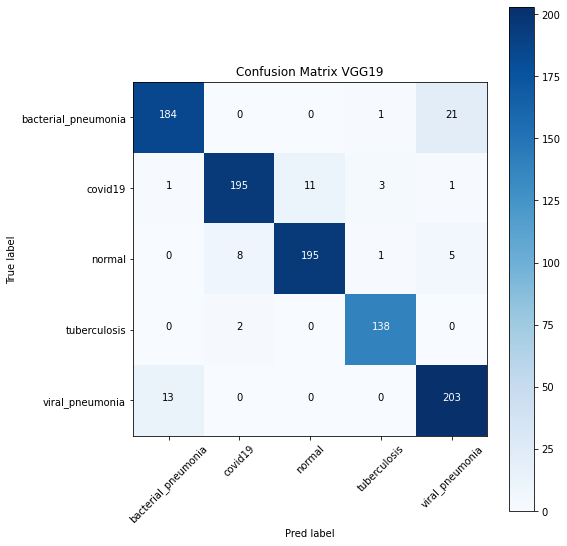

In [32]:
test_all_batches = datagen.flow_from_directory(
    directory=test_path,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    shuffle=False,
    class_mode="categorical",
)
true_labels = test_batches.classes

num_test_steps = len(test_all_batches)

predictions = model_vgg19.predict(test_batches, steps=num_test_steps, verbose=1)
predicted_labels = np.argmax(predictions, axis=1)
class_report = classification_report(
    true_labels, predicted_labels, target_names=train_batches.class_indices, digits=5
)
print("\nClassification Report VGG19:\n", class_report)

conf_matrix = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(8, 8))
plt.imshow(conf_matrix, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Confusion Matrix VGG19")
plt.colorbar()
tick_marks = np.arange(len(classname_label))
plt.xticks(tick_marks, classname_label, rotation=45)
plt.yticks(tick_marks, classname_label)
thresh = conf_matrix.max() / 2.0
for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
    plt.text(
        j,
        i,
        conf_matrix[i, j],
        horizontalalignment="center",
        color="white" if conf_matrix[i, j] > thresh else "black",
    )

plt.tight_layout()
plt.ylabel("True label")
plt.xlabel("Pred label")
plt.show()

In [33]:
y_true = np.array([])
for i in range(len(train_batches)):
    batch = next(train_batches)
    y_true = np.concatenate([y_true, np.argmax(batch[1], axis=1)])

classname_label = list(train_batches.class_indices.keys())
print(classname_label)

['bacterial_pneumonia', 'covid19', 'normal', 'tuberculosis', 'viral_pneumonia']


Found 6080 images belonging to 5 classes.
190/190 [==============================] - 33s 173ms/step

Training Classification Report VGG19:
                      precision    recall  f1-score   support

bacterial_pneumonia    0.97731   0.95328   0.96515      1220
            covid19    0.99423   0.97023   0.98208      1243
             normal    0.97299   0.99190   0.98236      1235
       tuberculosis    0.99659   0.99829   0.99744      1170
    viral_pneumonia    0.95185   0.97855   0.96501      1212

           accuracy                        0.97829      6080
          macro avg    0.97859   0.97845   0.97841      6080
       weighted avg    0.97853   0.97829   0.97829      6080



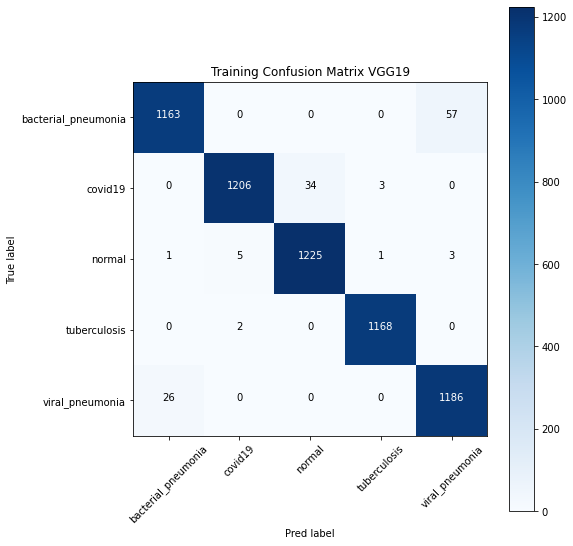

In [34]:
train_all_batches = datagen.flow_from_directory(
    directory=train_path,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    shuffle=False,
    class_mode="categorical",
)

num_train_steps = len(train_all_batches)

train_predictions = model_vgg19.predict(train_all_batches, steps=num_train_steps, verbose=1)
train_predicted_labels = np.argmax(train_predictions, axis=1)
train_true_labels = train_all_batches.classes

train_class_report = classification_report(
    train_true_labels,
    train_predicted_labels,
    target_names=train_all_batches.class_indices,
    digits=5,
)
print("\nTraining Classification Report VGG19:\n", train_class_report)

train_conf_matrix = confusion_matrix(train_true_labels, train_predicted_labels)

# Plot
plt.figure(figsize=(8, 8))
plt.imshow(train_conf_matrix, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Training Confusion Matrix VGG19")
plt.colorbar()

tick_marks = np.arange(len(classname_label))
plt.xticks(tick_marks, classname_label, rotation=45)
plt.yticks(tick_marks, classname_label)

thresh = train_conf_matrix.max() / 2.0
for i, j in itertools.product(
    range(train_conf_matrix.shape[0]), range(train_conf_matrix.shape[1])
):
    plt.text(
        j,
        i,
        train_conf_matrix[i, j],
        horizontalalignment="center",
        color="white" if train_conf_matrix[i, j] > thresh else "black",
    )

plt.tight_layout()
plt.ylabel("True label")
plt.xlabel("Pred label")
plt.show()

## InceptionV3

In [35]:
datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_v3.preprocess_input)

train_batches = datagen.flow_from_directory(train_path,
                                            target_size=(image_size,image_size),
                                            batch_size=batch_size,shuffle=True)

test_batches = datagen.flow_from_directory(test_path,
                                            target_size=(image_size,image_size),
                                            batch_size=batch_size,shuffle=False)

Found 6080 images belonging to 5 classes.
Found 982 images belonging to 5 classes.


In [36]:
base_model_inceptionv3 = tf.keras.applications.InceptionV3(
    include_top=False, weights="imagenet", input_shape=(image_size, image_size, 3)
)

for layer in base_model_inceptionv3.layers:
    layer.trainable = False

87924736/87910968 [==============================] - 0s 0us/step


In [37]:
model_inceptionv3 = Sequential()
model_inceptionv3.add(base_model_inceptionv3)
model_inceptionv3.add(GlobalAveragePooling2D())
model_inceptionv3.add(BatchNormalization())
model_inceptionv3.add(Dense(128, activation='relu'))
model_inceptionv3.add(Dropout(0.25))
model_inceptionv3.add(Dense(64, activation="relu"))
model_inceptionv3.add(Dropout(0.5))
model_inceptionv3.add(Dense(32, activation="relu"))
model_inceptionv3.add(Dense(5, activation="softmax"))

model_inceptionv3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 5, 5, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
batch_normalization_96 (Batc (None, 2048)              8192      
_________________________________________________________________
dense_8 (Dense)              (None, 128)               262272    
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)               

In [38]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)

model_inceptionv3.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['acc'])

checkpoint = ModelCheckpoint(
    filepath="/kaggle/working/file_training/inceptionv3.h5",
    monitor="val_acc",
    save_best_only=True,
    verbose=1,
    mode="max",
)

reduce_lr = ReduceLROnPlateau(
    monitor="val_acc",
    factor=0.5,
    patience=2,
    verbose=1,
    mode="max",
    min_lr=1e-6,
)

early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=7,
    restore_best_weights=True,
)

In [39]:
history_inceptionv3 = model_inceptionv3.fit(train_batches, validation_data=test_batches, epochs=25, verbose=1, callbacks=[early_stopping, reduce_lr])

Epoch 1/25
190/190 [==============================] - 32s 140ms/step - loss: 0.9669 - acc: 0.5979 - val_loss: 0.5942 - val_acc: 0.7760
Epoch 2/25
190/190 [==============================] - 24s 128ms/step - loss: 0.6961 - acc: 0.7058 - val_loss: 0.4944 - val_acc: 0.8024
Epoch 3/25
190/190 [==============================] - 25s 130ms/step - loss: 0.6171 - acc: 0.7388 - val_loss: 0.4566 - val_acc: 0.8320
Epoch 4/25
190/190 [==============================] - 24s 127ms/step - loss: 0.5515 - acc: 0.7671 - val_loss: 0.4202 - val_acc: 0.8473
Epoch 5/25
190/190 [==============================] - 25s 130ms/step - loss: 0.5152 - acc: 0.7811 - val_loss: 0.4074 - val_acc: 0.8534
Epoch 6/25
190/190 [==============================] - 24s 128ms/step - loss: 0.4735 - acc: 0.8003 - val_loss: 0.4146 - val_acc: 0.8462
Epoch 7/25
190/190 [==============================] - 24s 128ms/step - loss: 0.4377 - acc: 0.8201 - val_loss: 0.3950 - val_acc: 0.8513

Epoch 00007: ReduceLROnPlateau reducing learning rate 

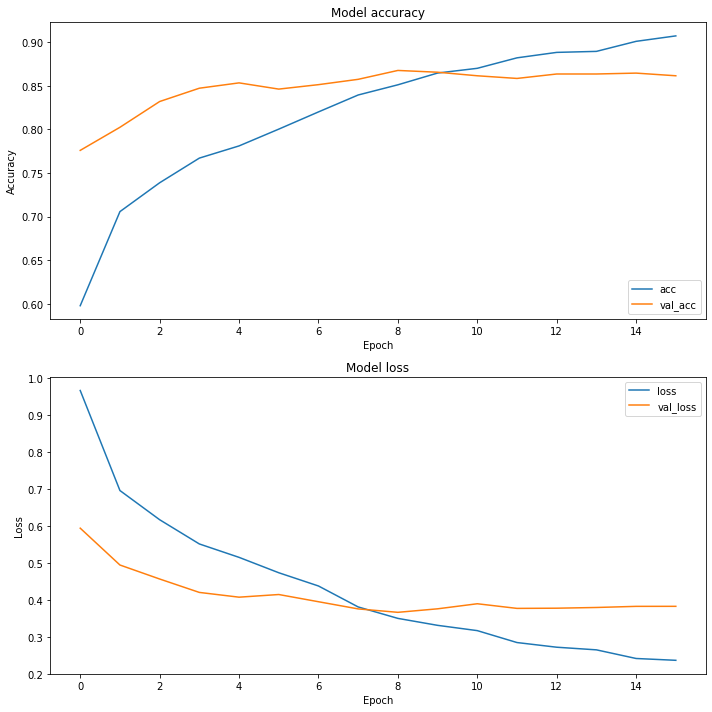

In [40]:
plt.figure(figsize=(10,10))
# Plot grafik akurasi
plt.subplot(2, 1, 1)
plt.plot(history_inceptionv3.history["acc"])
plt.plot(history_inceptionv3.history["val_acc"])
plt.title("Model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["acc", "val_acc"], loc="lower right")

# Plot grafik loss
plt.subplot(2, 1, 2)
plt.plot(history_inceptionv3.history["loss"])
plt.plot(history_inceptionv3.history["val_loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["loss", "val_loss"], loc="upper right")

plt.tight_layout()  # Agar grafik tidak tumpang tindih
plt.show()


In [41]:
train_score = model_inceptionv3.evaluate(train_batches, verbose=1)
test_score = model_inceptionv3.evaluate(test_batches, verbose=1)

31/31 [==============================] - 4s 137ms/step - loss: 0.3663 - acc: 0.8676


In [42]:
model_inceptionv3.save("/kaggle/working/file_training/inceptionv3.h5")

In [43]:
y_true = np.array([])
for i in range(len(test_batches)):
    batch = next(test_batches)
    y_true = np.concatenate([y_true, np.argmax(batch[1], axis=1)])

classname_label = list(test_batches.class_indices.keys())
print(classname_label)

['bacterial_pneumonia', 'covid19', 'normal', 'tuberculosis', 'viral_pneumonia']


Found 982 images belonging to 5 classes.
31/31 [==============================] - 5s 131ms/step

Classification Report InceptionV3 :
                      precision    recall  f1-score   support

bacterial_pneumonia    0.80282   0.83010   0.81623       206
            covid19    0.92056   0.93365   0.92706       211
             normal    0.91795   0.85646   0.88614       209
       tuberculosis    0.93103   0.96429   0.94737       140
    viral_pneumonia    0.79070   0.78704   0.78886       216

           accuracy                        0.86762       982
          macro avg    0.87261   0.87431   0.87313       982
       weighted avg    0.86823   0.86762   0.86760       982



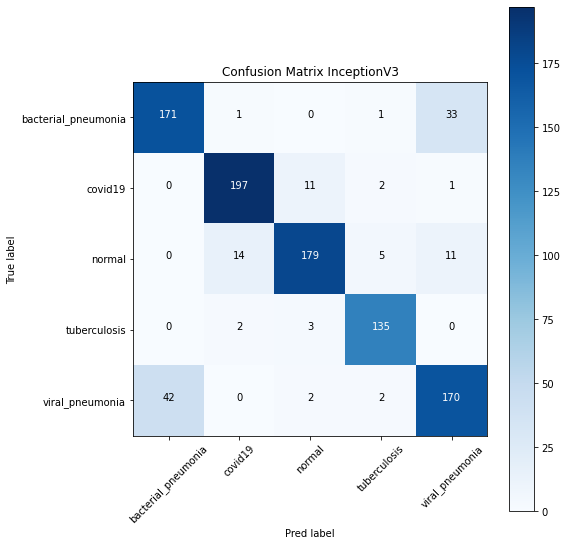

In [44]:
test_all_batches = datagen.flow_from_directory(
    directory=test_path,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    shuffle=False,
    class_mode="categorical",
)
true_labels = test_batches.classes
# model.load_weights("VGG16fix.hdf5")

num_test_steps = len(test_all_batches)

predictions = model_inceptionv3.predict(test_batches, steps=num_test_steps, verbose=1)
predicted_labels = np.argmax(predictions, axis=1)
class_report = classification_report(
    true_labels, predicted_labels, target_names=train_batches.class_indices, digits=5
)
print("\nClassification Report InceptionV3 :\n", class_report)

conf_matrix = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(8, 8))
plt.imshow(conf_matrix, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Confusion Matrix InceptionV3")
plt.colorbar()
tick_marks = np.arange(len(classname_label))
plt.xticks(tick_marks, classname_label, rotation=45)
plt.yticks(tick_marks, classname_label)
thresh = conf_matrix.max() / 2.0
for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
    plt.text(
        j,
        i,
        conf_matrix[i, j],
        horizontalalignment="center",
        color="white" if conf_matrix[i, j] > thresh else "black",
    )

plt.tight_layout()
plt.ylabel("True label")
plt.xlabel("Pred label")
plt.show()

In [45]:
y_true = np.array([])
for i in range(len(train_batches)):
    batch = next(train_batches)
    y_true = np.concatenate([y_true, np.argmax(batch[1], axis=1)])

classname_label = list(train_batches.class_indices.keys())
print(classname_label)

['bacterial_pneumonia', 'covid19', 'normal', 'tuberculosis', 'viral_pneumonia']


Found 6080 images belonging to 5 classes.
190/190 [==============================] - 21s 109ms/step

Training Classification Report InceptionV3 :
                      precision    recall  f1-score   support

bacterial_pneumonia    0.83429   0.83361   0.83395      1220
            covid19    0.97080   0.96299   0.96688      1243
             normal    0.95480   0.95789   0.95635      1235
       tuberculosis    0.99393   0.98034   0.98709      1170
    viral_pneumonia    0.81700   0.83251   0.82468      1212

           accuracy                        0.91332      6080
          macro avg    0.91417   0.91347   0.91379      6080
       weighted avg    0.91395   0.91332   0.91361      6080



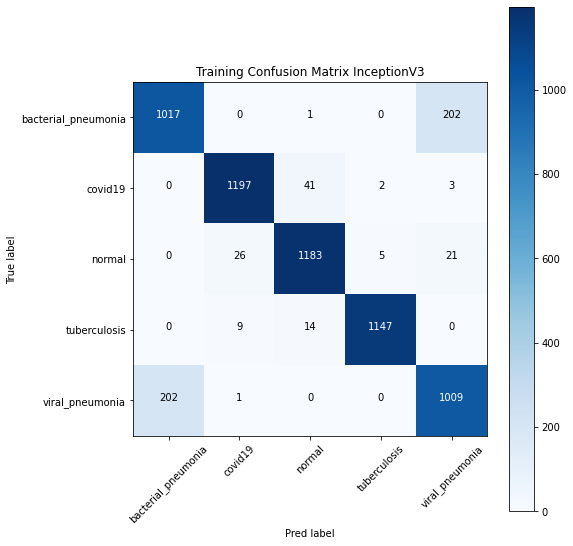

In [46]:
train_all_batches = datagen.flow_from_directory(
    directory=train_path,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    shuffle=False,
    class_mode="categorical",
)

num_train_steps = len(train_all_batches)

train_predictions = model_inceptionv3.predict(train_all_batches, steps=num_train_steps, verbose=1)
train_predicted_labels = np.argmax(train_predictions, axis=1)
train_true_labels = train_all_batches.classes

train_class_report = classification_report(
    train_true_labels,
    train_predicted_labels,
    target_names=train_all_batches.class_indices,
    digits=5,
)
print("\nTraining Classification Report InceptionV3 :\n", train_class_report)

train_conf_matrix = confusion_matrix(train_true_labels, train_predicted_labels)

# Plot
plt.figure(figsize=(8, 8))
plt.imshow(train_conf_matrix, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Training Confusion Matrix InceptionV3")
plt.colorbar()

tick_marks = np.arange(len(classname_label))
plt.xticks(tick_marks, classname_label, rotation=45)
plt.yticks(tick_marks, classname_label)

thresh = train_conf_matrix.max() / 2.0
for i, j in itertools.product(
    range(train_conf_matrix.shape[0]), range(train_conf_matrix.shape[1])
):
    plt.text(
        j,
        i,
        train_conf_matrix[i, j],
        horizontalalignment="center",
        color="white" if train_conf_matrix[i, j] > thresh else "black",
    )

plt.tight_layout()
plt.ylabel("True label")
plt.xlabel("Pred label")
plt.show()

## Ensamble Learning

In [82]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, concatenate
import tensorflow as tf


model1_path = '/kaggle/working/file_training/resnet50.h5'
model2_path = '/kaggle/working/file_training/vgg19.h5'

model1 = load_model(model1_path)
model1 = Model(inputs=model1.inputs, outputs=model1.outputs, name='model_resnet')

model2 = load_model(model2_path)
model2 = Model(inputs=model2.inputs, outputs=model2.outputs, name='model_vgg')

model_input = Input(shape=(image_size, image_size, 3))
model_outputs = [model(model_input) for model in [model1, model2]]

merged_output = concatenate(model_outputs)
x = Dense(128, activation='relu')(merged_output)
x = Dropout(0.5)(x)
x = Dense(32, activation='relu')(x)
output = Dense(5, activation='softmax')(x)

ensemble_model = Model(inputs=model_input, outputs=output, name='ensemble_model')

ensemble_model.summary()


Model: "ensemble_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
model_resnet (Functional)       (None, 5)            23868677    input_11[0][0]                   
__________________________________________________________________________________________________
model_vgg (Functional)          (None, 5)            20102597    input_11[0][0]                   
__________________________________________________________________________________________________
concatenate_8 (Concatenate)     (None, 10)           0           model_resnet[0][0]               
                                                                 model_vgg[0][0]     

In [83]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
ensemble_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['acc'])

# Train the ensemble model
history_ensemble = ensemble_model.fit(
    train_batches,
    validation_data=test_batches,
    epochs=25,
    verbose=1
)

Epoch 1/25
190/190 [==============================] - 63s 313ms/step - loss: 1.0132 - acc: 0.6081 - val_loss: 1.2994 - val_acc: 0.3900
Epoch 2/25
190/190 [==============================] - 59s 309ms/step - loss: 0.6822 - acc: 0.7191 - val_loss: 0.6084 - val_acc: 0.7322
Epoch 3/25
190/190 [==============================] - 59s 308ms/step - loss: 0.6102 - acc: 0.7500 - val_loss: 0.4382 - val_acc: 0.8065
Epoch 4/25
190/190 [==============================] - 59s 308ms/step - loss: 0.5463 - acc: 0.7891 - val_loss: 0.3909 - val_acc: 0.8340
Epoch 5/25
190/190 [==============================] - 59s 309ms/step - loss: 0.5107 - acc: 0.8000 - val_loss: 0.3750 - val_acc: 0.8554
Epoch 6/25
190/190 [==============================] - 59s 310ms/step - loss: 0.4823 - acc: 0.8184 - val_loss: 0.3343 - val_acc: 0.8788
Epoch 7/25
190/190 [==============================] - 59s 309ms/step - loss: 0.4570 - acc: 0.8334 - val_loss: 0.3189 - val_acc: 0.8829
Epoch 8/25
190/190 [==============================] - 5

In [84]:
train_score_ensemble = ensemble_model.evaluate(train_batches, verbose=1)
test_score_ensemble = ensemble_model.evaluate(test_batches, verbose=1)

31/31 [==============================] - 8s 266ms/step - loss: 0.2280 - acc: 0.9094


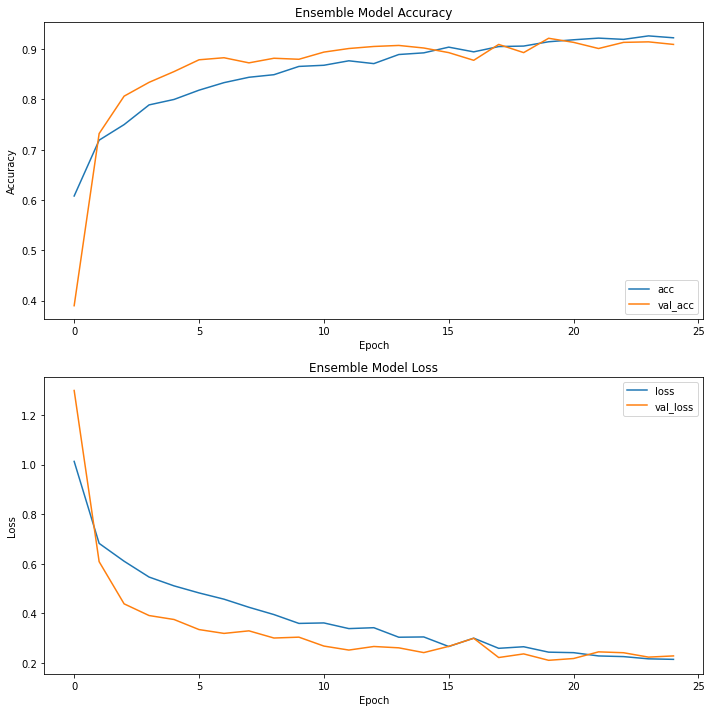

In [85]:
plt.figure(figsize=(10,10))
plt.subplot(2, 1, 1)
plt.plot(history_ensemble.history["acc"])
plt.plot(history_ensemble.history["val_acc"])
plt.title("Ensemble Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["acc", "val_acc"], loc="lower right")

plt.subplot(2, 1, 2)
plt.plot(history_ensemble.history["loss"])
plt.plot(history_ensemble.history["val_loss"])
plt.title("Ensemble Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["loss", "val_loss"], loc="upper right")

plt.tight_layout()
plt.show()


In [86]:
# model.save("/kaggle/working/file_training/ensemble_model.h5")